# Tanzania Water Resources
## 1. Exploratory Data Analysis

Importing the required packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
import time
import pickle #To save the objects 
import pprint
from lxml import html
import requests
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from urllib.request import urlopen
from bs4 import BeautifulSoup
from IPython.display import HTML
import re
import urllib
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the data
We are given the following data sets:
* training_data.csv (Contains the training data)
* training_labels.csv (Contains the target labels)
* test_data.csv (test data)

Let us read training_data.csv and training_labels.csv, and combine them to form a single data frame. The combined training data will help us to perform the EDA easily.

In [2]:
training_values = pd.read_csv('training_data.csv')
training_labels = pd.read_csv('training_labels.csv')

In [3]:
display(training_values.head())
training_values.shape

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


(59400, 40)

In [4]:
display(training_labels.head())
training_labels.shape

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


(59400, 2)

Let us combine the training_labels and training_values, to form training_data dataframe.

In [5]:
training_data = training_values.join(training_labels,on=["id"],
                     how='inner',lsuffix='_values', 
                     rsuffix='labels').drop('id_values',axis=1)
training_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,idlabels,status_group
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,13732,non functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,16417,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,45242,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,20867,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,3055,non functional


In [6]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47492 entries, 1 to 59399
Data columns (total 42 columns):
id                       47492 non-null int64
amount_tsh               47492 non-null float64
date_recorded            47492 non-null object
funder                   44596 non-null object
gps_height               47492 non-null int64
installer                44580 non-null object
longitude                47492 non-null float64
latitude                 47492 non-null float64
wpt_name                 47492 non-null object
num_private              47492 non-null int64
basin                    47492 non-null object
subvillage               47182 non-null object
region                   47492 non-null object
region_code              47492 non-null int64
district_code            47492 non-null int64
lga                      47492 non-null object
ward                     47492 non-null object
population               47492 non-null int64
public_meeting           44854 non-null object
r

### Analysis of amount_tsh
Represents the "Total Static Head". 

As per http://sciencing.com/calculate-static-head-7255224.html
Static head measures the total vertical distance that a pump raises water. It has two components: static lift and static discharge. Static lift measures the elevation difference between the water source and the pump, while static discharge measures the elevation difference between the discharge point and the pump. Pump head describes pressure in terms of distance, usually in feet or meters. Pressure can be converted between units of distance and units of force per unit area: 2.31 ft of head equals 1 psi (pound per square inch) of pressure.

Subtract the elevation of the water source from the elevation of the center line of the pump to determine static lift.

Subtract the elevation of the center line of the pump from the elevation of the discharge point of the water to determine the static discharge.

Add static lift and static discharge to obtain the total static head.


Tip
Ensure that the signs are correct throughout your calculations. For example, static lift will be positive if the water source lies below the pump, but negative if it lies above the pump. Drawing a diagram of the system may help you visualize the elevation changes.

In [7]:
df = training_data
#training_data['amount_tsh'].unique()
df['amount_tsh'].value_counts()

0.0         33240
500.0        2481
50.0         1972
20.0         1170
1000.0       1166
200.0         989
10.0          664
100.0         653
30.0          591
2000.0        564
250.0         467
300.0         434
5000.0        367
5.0           296
25.0          283
3000.0        267
1200.0        211
1500.0        163
6.0           154
600.0         145
4000.0        128
2400.0        115
2500.0        108
6000.0        103
7.0            60
750.0          52
40.0           50
10000.0        48
8000.0         47
12000.0        46
            ...  
16300.0         2
4500.0          2
520.0           2
350.0           2
590.0           2
45000.0         2
16000.0         2
0.2             2
13000.0         1
138000.0        1
53.0            1
900.0           1
220.0           1
200000.0        1
26000.0         1
12.0            1
9.0             1
8500.0          1
1400.0          1
800.0           1
120000.0        1
26.0            1
59.0            1
6300.0          1
60000.0   

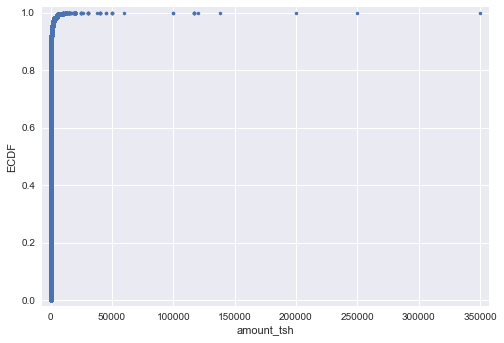

In [8]:
def ECDF(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y
x,y = ECDF(df[df['amount_tsh']<10000000]['amount_tsh'])
plt.plot(x,y,marker='.',linestyle='none')
plt.xlabel("amount_tsh")
plt.ylabel("ECDF")
plt.margins(0.02)
plt.show()

Out of 59400 values, 33240 have 0. This means the value of 0 could be representing an unknown value or it could be a genuine value. In any case, we should use std. scaler method to transform this variable, since min-max scaler will be effected by outliers.

Before analyzing any categorical variable, let us define a helper function to draw a scatter plot, that shows the status of pumps out of the total pumps, grouped by the categorical variable in question.

In [9]:
def plot_status_split(df,col):
    '''
       df = Data Frame, along with the status_group variable
       col = categorical variable
    '''
    import seaborn as sns
    sns.set(style="darkgrid")

    #Get the total pumps at the given col level
    total_count=df.groupby([col]).size().reset_index()
    total_count.columns=[col,'total']
    total_count.index = total_count[col]
    total_count = total_count.drop([col],axis=1)

    #display(total_count.head())

    status_count = df.groupby([col,'status_group']).size().reset_index()
    status_count.columns=[col,'status_group','status_total']
    status_count.index = status_count[col]
    status_count = status_count.drop([col],axis=1)
    #display(status_count.head())
    joined_df = total_count.join(status_count,how='left')

    joined_df['percent'] = joined_df['status_total']/joined_df['total'] * 100
    #display(joined_df.head())
    
    sns.lmplot('total', 'status_total', data=joined_df, hue='status_group', fit_reg=False)
    #sns.lmplot('total', 'percent', data=joined_df, hue='status_group', fit_reg=False)
    
    plt.xlabel("Total pumps at " +col+" level")
    plt.ylabel("Pumps status counts")
    plt.title("Relationship between pumps states and " + col + " variable")
    plt.show()

### Analyzing _funder_ column
The _funder_ column refers to the entity who has funded the water project. This column is a categorical column. Let us display some of the rows of this column:

In [10]:
#Displaying some of the rows which have NULL values for funder.
df[df['funder'].isnull()].head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,idlabels,status_group
34,41583,0.0,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,...,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,43984,functional needs repair
43,19282,0.0,2013-01-15,NaN,1642,NaN,34.967789,-4.628921,Mvae Primary,0,...,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,776,non functional
47,13620,0.0,2011-07-27,NaN,0,NaN,33.540607,-9.172905,Mahakamani,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,59731,non functional
65,51072,0.0,2013-02-09,NaN,1415,NaN,34.621598,-5.173136,Nyambi,0,...,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,54251,functional
71,17386,0.0,2011-03-31,NaN,0,NaN,34.462228,-8.575780,Kwa Manyusi Mlilo,0,...,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,61362,functional


In [11]:
##Change the funder's Null values to unknown
df['funder'].fillna('unknown',inplace=True)

Now that we changed the null values to unknown, let us see how the pupms status change based on the number of pumps funded by the funder.

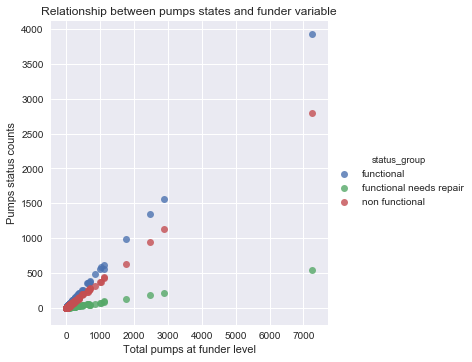

In [12]:
plot_status_split(df,'funder')

There is clearly a linear trend in the pumps status. We may have to create dummy variables that capture the number of pumps (ranges) sponsored by the funders.

Let us analyze the funders name. The funders name is a free form text, so we may see that same funder might be spelled differently.

In [13]:
##Looks like the text in funder is a free form text. 
funder_summary = pd.DataFrame(df['funder'].str.lower().value_counts().reset_index())
funder_summary.columns = ['funder','count']
print(funder_summary.sort_values(['funder']).head(25))

                           funder  count
15                              0    616
355                  a/co germany     10
223                           aar     22
159                        abasia     34
976   abc-ihushi development cent      1
476                           abd      6
1027                       abdala      1
1648                       abddwe      1
1636                        abdul      1
675                         abood      2
919                           abs      1
368                   aco/germany     10
843                         acord      2
1323                    acord ngo      1
141                          acra     39
1335                          act      1
849                      act mara      1
474                    action aid      6
435         action contre la faim      7
1156                  action in a      1
527                          adap      4
22                            adb    371
502                           adf      5
232             

Clearly we can see that there are some funders spelled differently, although they refer to the same funder (see a/co germany) and (aco/germany). Another example is "acord" and "acord ngo". We will use fuzzywuzzy package to map the similar funders.

In [14]:
print(funder_summary.sort_values(['count'],ascending=False).head(25))
print(np.sum(funder_summary.sort_values(['count'],ascending=False).head(25)["count"]))

                    funder  count
0   government of tanzania   7252
1                  unknown   2900
2                   danida   2479
3                   hesawa   1746
4               world bank   1115
5                    rwssp   1106
6                     kkkt   1026
7             world vision    996
8                   unicef    844
9                    tasaf    687
10        district council    684
11      private individual    666
12                     dhv    654
13                    dwsp    651
14                   norad    624
15                       0    616
16         germany republi    491
17                    tcrs    478
18                   water    463
19       ministry of water    463
20             netherlands    380
21                     dwe    377
22                     adb    371
23                     lga    359
24                   hifab    349
27777


To restrict the number of dummy variables, we will only consider the top 25 funders. However, there are some funder names which are spelled differently, although they belong to one of the top 25 funders. The remaining funders (who are not in top 25 or who do not belong to top 25 funders), will be treated as unknown funders. 

In the above diplay, we can see that 2900 funders have the name "unknown". Actually these funders do not have any name (null values), and we imputed with "unknown" in the previous step.

There are some funders with "0" as the name. Looks like these also belong to "unknown". The "norad" meand "Norwegian Ministry of Foreign Affairs (NORAD)", and it should belong to Netherlands. The "ministry of water" and "water" should belong to the same funder. You can observe that both have the same number of observations 463. Is that coincidence or is there any duplicaion of the data??

See the document http://theredddesk.org/sites/default/files/combating_desertification_programme_1.pdf for the abbrivations such as dwe etc.

Looks like African Development Bank has many projects. https://www.afdb.org/en/topics-and-sectors/sectors/water-supply-sanitation/projects-activities/activities-in-tanzania/

Using the top 25 list, along with the help of google and above docs, I came up with the following mapping logic.

In [15]:
#reqired packages to perform fuzzy matching
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

funder_dict = {"government of tanzania": "tanzania government",
              "unknown":"unknown",
              "danida":"denmark",
              "hesawa":"hesawa",
              "world bank":"world bank",
              "rwssp":"rwssp",
              "kkkt":"church",
              "church":"church", 
               "baptist":"church",
              "world vision":"world vision",
              "unicef":"unicef",
              "tasaf":"tasaf",
              "district council":"tanzania district government",
              "private individual":"unknown",
               "community":"local community",
               "dhv":"dhv",
               "dwsp":"dwsp",
               "norad":"netherlands",
               "0": "unknown",
               "germany":"germany",
               "tcrs":"tcrs",
               "ministry of water":"ministry of water",
               "water":"ministry of water",
               "netherlands":"netherlands",
               "dwe":"tanzania government",
               "adb":"african development bank",
               "african development bank":"african development bank",
               "lga":"tanzania local government",
               "hifab":"hifab",
               "urban water supply and sanitation project for zanzibar":"african development bank",
               "rural water supply and sanitation":"african development bank",
               "nsgrp":"tanzania government",
               "monduli district water":"african development bank"
               
              }

#Create another column funder_new.
#Populate this as follows:
#For each value in funder, if there is an exact match with a key in above dict, then use the value of the above dict
#If there is NO match, then use values of the above dict, and perform fuzzy match
#If there is a match with a score of 80 or more, then use the value, else use "other"
#Finally we will replace funder with funder_new

#funder_dict['sekhar']
def find_and_replace(l,map_dict):
    funder_new = []
    for j in list(l):
        try:
            funder_new.append(map_dict[str(j).lower()])
            continue
        except:
            word,score = process.extract(j, map_dict.keys(), limit=1)[0]

            if score > 85:
                funder_new.append(map_dict[word])
            else:
                funder_new.append("unknown")
    return funder_new        
funder_new = find_and_replace(df['funder'],funder_dict)
#df['funder_new'] = funder_new    

In [16]:
#After mapping
df["funder_new"] = funder_new
print(df[["funder","funder_new"]])
#set(funder_new)
print(pd.DataFrame(df['funder_new'].str.lower().value_counts().reset_index()))

                         funder                    funder_new
1                       Grumeti                       unknown
2                  Lottery Club                       unknown
4                   Action In A                       unknown
5           Mkinga Distric Coun                       unknown
6                          Dwsp                          dwsp
7                         Rwssp                         rwssp
8                      Wateraid             ministry of water
9                   Isingiro Ho                       unknown
10                      Private                       unknown
11                       Danida                       denmark
12                 World Vision                  world vision
13      Lawatefuka Water Supply             ministry of water
14                        Biore                       unknown
16                       Unicef                        unicef
17                       Unicef                        unicef
18      

How does the trend look after grouping the funders?

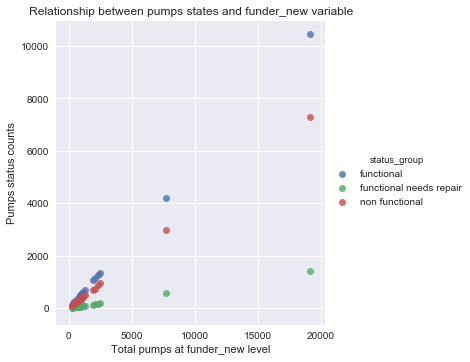

In [17]:
plot_status_split(df,'funder_new')

### Analyzing gps_height
The gps_height column contains the hight above the sea level (units unknown). 

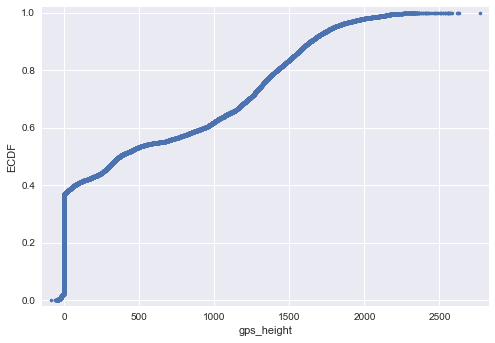

In [18]:
def ECDF(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y
x,y = ECDF(df['gps_height'])
plt.plot(x,y,marker='.',linestyle='none')
plt.xlabel("gps_height")
plt.ylabel("ECDF")
plt.margins(0.02)
plt.show()

Approximately 38% of the gps_height values have a value of less than or equal to 0. Negative altitude is possible, if the area lies below the sealevel. As per https://en.wikipedia.org/wiki/Sea_level, it is very difficult to measure the sealevel accurately, so we will leave this variable as it is, but we will scale it using std. scaler.

## Analyzing installer
It is a categorical variable

In [19]:
df['installer'].value_counts()

DWE                           13981
Government                     1434
RWE                             970
Commu                           843
DANIDA                          822
KKKT                            721
Hesawa                          653
0                               616
TCRS                            556
Central government              513
CES                             491
Community                       446
District Council                443
DANID                           441
HESAWA                          428
World vision                    333
LGA                             329
Gover                           309
WEDECO                          309
District council                305
TASAF                           303
TWESA                           268
AMREF                           259
Dmdd                            232
ACRA                            230
WU                              230
World Vision                    210
DW                          

In [20]:
##Change the installer's Null values to unknown
df['installer'].fillna('unknown',inplace=True)
df['installer'][df['installer'] == '-'] = 'unknown'
installer_new = find_and_replace(df['installer'],funder_dict)

In [21]:
df['installer']
df["installer_new"] = installer_new
print(df[["installer","installer_new"]])
#set(funder_new)
print(pd.DataFrame(df['installer_new'].str.lower().value_counts().reset_index()))

                  installer                 installer_new
1                   GRUMETI                       unknown
2              World vision                  world vision
4                   Artisan                       unknown
5                       DWE           tanzania government
6                      DWSP                          dwsp
7                       DWE           tanzania government
8                 Water Aid             ministry of water
9                   Artisan                       unknown
10                  Private                       unknown
11                   DANIDA                       denmark
12             World vision                  world vision
13     Lawatefuka water sup             ministry of water
14                   WEDECO                       unknown
16                      DWE           tanzania government
17                      DWE           tanzania government
18                      DWE           tanzania government
19            

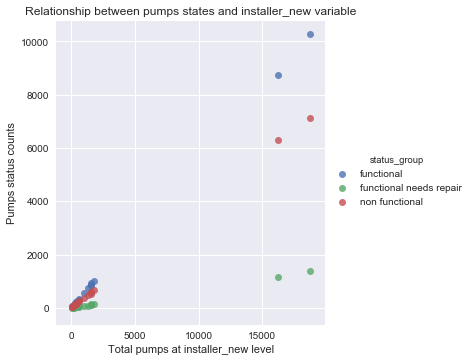

In [22]:
plot_status_split(df,'installer_new')

## funder_installer_same (new variable)
Let us create a new variable called funder_installer_same. We will use fuzzy matching, and call it a match, if the score is at least 85, else mismatch. If the funder and the installer are the same for a project, then it is possible that the quality of the pump installation might vary. 

In [23]:
funder_installer_same = list()
for i, j in zip(list(df['funder']),list(df['installer'])):
    if (fuzz.ratio(i,j) >= 85 or fuzz.partial_ratio(i,j) >= 85 or fuzz.token_sort_ratio(i,j) >= 85) and \
         (i != 'unknown' and j != 'unknown') :
        funder_installer_same.append(1)
        continue
    else:
        funder_installer_same.append(0)
df["funder_installer_same"] = funder_installer_same

In [24]:
print(df["funder_installer_same"].value_counts())
perc = df["funder_installer_same"].value_counts().iloc[1]/np.sum(df["funder_installer_same"].value_counts()) * 100
print("Approximately {} pumps were installed by the same organization who funded the project.".format(perc))

0    28797
1    18695
Name: funder_installer_same, dtype: int64
Approximately 39.36452455150341 pumps were installed by the same organization who funded the project.


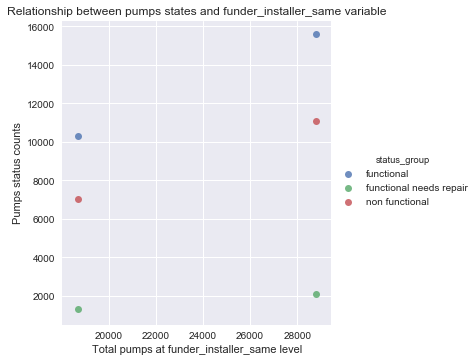

In [25]:
plot_status_split(df,'funder_installer_same')

## latitude and longitude

Let us analyze these two columns. How many of these two columns have 0s or null values?

In [26]:
print("There are {} rows with unknown latitude and longitude values". \
      format(sum((np.round(df['latitude']) == 0) | (np.round(df['longitude']) == 0))))


There are 1452 rows with unknown latitude and longitude values


Latitude and longitude of 0 (after rounding is incorrect). 0 might represent unknown value. We will use average of latitude and longitute, group by _ward_ column to populate missing latitude and longitude values respectively.

The _ward_ column represents the ward name, and none of the values of this column are unknown or nulls. Moreover _ward_ is the smallest region size given in the data set (https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania).

However, if all the latitudes and longitudes of a ward are 0, then we should consider the next level, _lga_, the local government authority. The _lga_ also do not have any null values. If the _lga_ level also has 0 latitude/longitude, then we will use group by at region level. At region column also has no null values. While it is unlikely, there is a chance that region level may also have 0 latitude and longitude. If this happens, we want to be alerted, so that we can check the incoming data.

In [27]:
print(sum(df['ward'].isnull()))
print(sum(df['lga'].isnull()))
print(sum(df['region'].isnull()))

0
0
0


In [28]:
avg_lat_long_by_ward_df = df[df['longitude'] != 0]. \
groupby(['ward'])['latitude','longitude'].mean().reset_index()
avg_lat_long_by_ward_df.columns=['ward','avg_latitude','avg_longitude']

avg_lat_long_by_lga_df = df[df['longitude'] != 0]. \
groupby(['lga'])['latitude','longitude'].mean().reset_index()
avg_lat_long_by_lga_df.columns=['lga','avg_latitude','avg_longitude']

avg_lat_long_by_region_df = df[df['longitude'] != 0]. \
groupby(['region'])['latitude','longitude'].mean().reset_index()

avg_lat_long_by_region_df.columns=['region','avg_latitude','avg_longitude']


print(avg_lat_long_by_ward_df.head())
print("\n\n")
print(avg_lat_long_by_lga_df.head())
print("\n\n")
print(avg_lat_long_by_region_df.head())



           ward  avg_latitude  avg_longitude
0       Aghondi     -5.755730      34.694762
1        Akheri     -3.361883      36.777325
2         Arash     -2.303697      35.519736
3          Arri     -4.226358      35.592262
4  Arusha Chini     -3.489477      37.350959



            lga  avg_latitude  avg_longitude
0  Arusha Rural     -3.361613      36.700674
1  Arusha Urban     -3.391959      36.686171
2        Babati     -4.145967      35.674411
3      Bagamoyo     -6.460694      38.608572
4          Bahi     -6.074641      35.528436



          region  avg_latitude  avg_longitude
0         Arusha     -3.246777      36.555548
1  Dar es Salaam     -6.910724      39.218210
2         Dodoma     -5.931256      36.044719
3         Iringa     -8.910737      34.897560
4         Kagera     -1.966391      31.230113


In [29]:
avg_lat_ward_dict = dict(zip(list(avg_lat_long_by_ward_df['ward']),list(avg_lat_long_by_ward_df['avg_latitude'])))
avg_long_ward_dict = dict(zip(list(avg_lat_long_by_ward_df['ward']),list(avg_lat_long_by_ward_df['avg_longitude'])))

avg_lat_lga_dict = dict(zip(list(avg_lat_long_by_lga_df['lga']),list(avg_lat_long_by_ward_df['avg_latitude'])))
avg_long_lga_dict = dict(zip(list(avg_lat_long_by_lga_df['lga']),list(avg_lat_long_by_ward_df['avg_longitude'])))

avg_lat_region_dict = dict(zip(list(avg_lat_long_by_region_df['region']),\
                               list(avg_lat_long_by_region_df['avg_latitude'])))

avg_long_region_dict = dict(zip(list(avg_lat_long_by_region_df['region']),\
                                list(avg_lat_long_by_region_df['avg_longitude'])))


In [30]:
latitude = []
longitude = []
for (i, j, k, l, m) in zip(list(df['latitude']),list(df['longitude']), \
                        list(df['ward']),list(df['lga']),list(df['region'])):
    if np.round(j) == 0 or np.round(j) == 0:
        try:
            latitude.append(avg_lat_ward_dict[k])
            longitude.append(avg_long_ward_dict[k])
        except:
            try:
                latitude.append(avg_lat_lga_dict[l])
                longitude.append(avg_long_lga_dict[l])
                continue
            except:
                try:
                    latitude.append(avg_lat_region_dict[m])
                    longitude.append(avg_long_region_dict[m])
                    continue
                except:   
                    print("Lat/Long NOT found at region level also. Terminating..")
    else:
        latitude.append(i)
        longitude.append(j)        


In [31]:
df["latitude_new"] = latitude
df["longitude_new"] = longitude

In [32]:
print(df[["latitude","latitude_new","longitude","longitude_new"]][df["longitude"] == 0])

           latitude  latitude_new  longitude  longitude_new
21    -2.000000e-08     -5.639425        0.0      35.687971
53    -2.000000e-08     -2.615618        0.0      33.087889
177   -2.000000e-08     -2.890831        0.0      34.094610
253   -2.000000e-08     -1.199354        0.0      31.817468
256   -2.000000e-08     -2.615618        0.0      33.087889
321   -2.000000e-08     -5.639425        0.0      35.687971
323   -2.000000e-08     -2.708503        0.0      33.602357
326   -2.000000e-08     -2.615618        0.0      33.087889
346   -2.000000e-08     -5.639425        0.0      35.687971
370   -2.000000e-08     -2.615618        0.0      33.087889
433   -2.000000e-08     -5.639425        0.0      35.687971
659   -2.000000e-08     -5.639425        0.0      35.687971
678   -2.000000e-08     -1.199354        0.0      31.817468
697   -2.000000e-08     -5.639425        0.0      35.687971
720   -2.000000e-08     -5.639425        0.0      35.687971
733   -2.000000e-08     -5.639425       

## Analyzing wpt_name
Ignore this column, as this contains the name of the water point. 

In [33]:
len(set(df['wpt_name']))

30643

## Analyzing num_private

The significance of this column is not given. Let us get the counts of the distinct values in this column:

In [34]:
df['num_private'].value_counts()

0       46899
6          61
1          56
5          40
8          37
15         29
32         29
45         28
39         25
93         23
3          19
7          18
4          17
2          17
65         16
47         16
17         14
102        14
20         12
80         11
25         10
41         10
11          9
34          8
16          7
22          6
120         6
50          5
150         5
24          5
12          3
61          3
58          3
38          2
9           2
14          2
10          2
27          2
26          2
42          1
160         1
672         1
1402        1
698         1
280         1
450         1
55          1
131         1
23          1
213         1
180         1
755         1
1776        1
240         1
111         1
300         1
136         1
62          1
Name: num_private, dtype: int64

In [35]:
print("Almost {}% of num_private are 0s".format(df['num_private'].value_counts()[0]/df.shape[0]*100))

Almost 98.75136865156236% of num_private are 0s


So ignore the num_private column

## Analyzing basin
This column does not have any null values, and the number of levels are also reasonable. Let us get the counts of distinct values:

In [36]:
print(sum(df['basin'].isnull()))
df['basin'].value_counts()

0


Lake Victoria              8098
Pangani                    7165
Rufiji                     6392
Internal                   6249
Lake Tanganyika            5205
Wami / Ruvu                4793
Lake Nyasa                 4053
Ruvuma / Southern Coast    3566
Lake Rukwa                 1971
Name: basin, dtype: int64

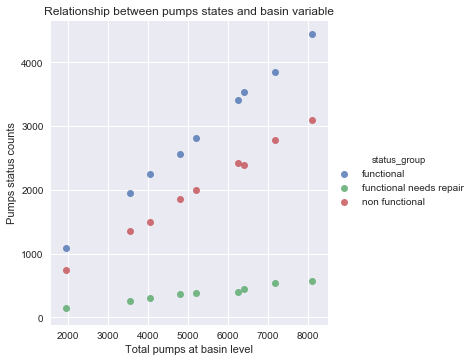

In [37]:
plot_status_split(df,'basin')

## Analyzing subvillage
This variable has null values, and also it has many levels.

In [38]:
#Number of null values
sum(df['subvillage'].isnull())

310

In [39]:
df['subvillage'].value_counts()

Shuleni           409
Majengo           405
Madukani          400
Kati              298
Mtakuja           208
Sokoni            174
M                 158
Muungano          144
Mbuyuni           128
Mlimani           119
Songambele        118
Msikitini         110
Miembeni          106
1                  95
Kibaoni            91
I                  86
Mapinduzi          86
Mjini              86
Mjimwema           85
Mkwajuni           85
Mwenge             83
Mabatini           81
Kanisani           81
Azimio             79
Mbugani            77
Zahanati           76
Mission            76
Misufini           73
Bwawani            72
Bondeni            71
                 ... 
Nyanghonge          1
Mfaranyake          1
Mwakijabende        1
Lyangalile          1
Momoka              1
Machadi             1
Meserani            1
Ushashili           1
Ukungwi             1
Mushule             1
Lirunde             1
Panga               1
Kichabgani          1
Ngyekye             1
Sijaona   

We will ignore the subvillege, since it has 17259 distinct classes, and also none of the classes represent significant number of rows in the column. We will revisit this later if our final model has very low score.

## Analyzing region
This column has no null values.

In [40]:
sum(df['region'].isnull())

0

In [43]:
print(df['region'].value_counts())

Iringa           4265
Shinyanga        4027
Mbeya            3700
Kilimanjaro      3479
Morogoro         3178
Arusha           2703
Kagera           2610
Mwanza           2458
Kigoma           2301
Pwani            2118
Ruvuma           2082
Tanga            2047
Dodoma           1777
Singida          1680
Tabora           1552
Mara             1528
Rukwa            1451
Mtwara           1383
Manyara          1277
Lindi            1239
Dar es Salaam     637
Name: region, dtype: int64


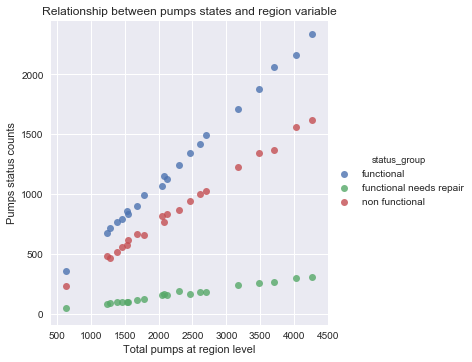

In [44]:
plot_status_split(df,'region')

## Analyzing region_code
This is the numeric representation of the region, and can be ignored. However we can see that the following counts and the counts on _region_ column are not the same. We will check this discrepancy later, if we decide to use region_code.

In [45]:
sum(df['region_code'].isnull())
print(df['region_code'].value_counts())

11    4270
17    4051
12    3700
3     3479
5     3200
18    2616
2     2443
19    2411
16    2301
10    2082
4     2025
1     1777
13    1680
14    1570
20    1528
15    1451
6     1286
21    1277
80    1003
60     831
90     730
7      637
99     347
9      306
24     260
8      230
40       1
Name: region_code, dtype: int64


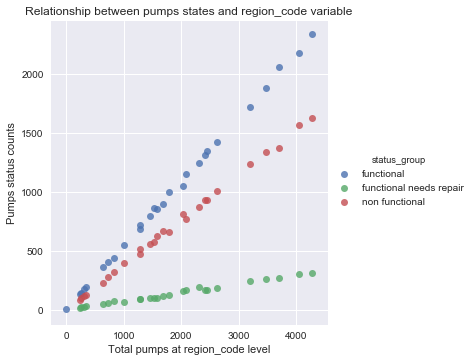

In [46]:
plot_status_split(df,'region_code')

## Analyzing district_code
Since we are using the _region_, I am not sure how important to use the district_code. But there might be a hidden signal on the pump's performance depending the district level government (if the district maintains/installed the pump).

In [47]:
print("District code has {} null values\n".format(sum(df['district_code'].isnull())))
print("Counts at the district code level:\n{}".format(df['district_code'].value_counts()))
print("\nNumber of districts represented in the data set {}".format(df['district_code'].value_counts().shape[0]))

District code has 0 null values

Counts at the district code level:
1     9715
2     9015
3     7987
4     7176
5     3477
6     3234
7     2668
8      827
30     799
33     699
53     612
43     423
13     315
23     227
63     154
62      83
60      47
0       19
80      10
67       5
Name: district_code, dtype: int64

Number of districts represented in the data set 20


As per https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania, Tanzania has 169 districts, but the data set has only 20 districts. As of now we will ignore district_code, but we will revisit our decision later

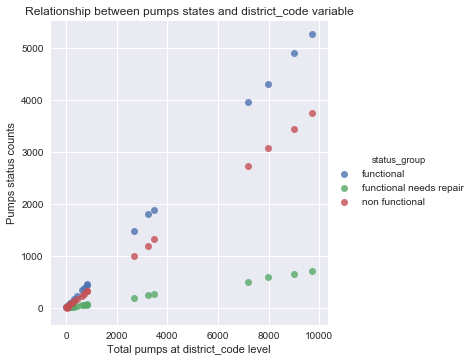

In [48]:
plot_status_split(df,'district_code')

## Analyzing lga
Analyzing lga - Local Governing Agency

In [49]:
print("lga has {} null values\n".format(sum(df['lga'].isnull())))
print("Counts at the lga levels:\n{}".format(df['lga'].value_counts()))
print("\nNumber of lga represented in the data set {}".format(df['lga'].value_counts().shape[0]))


lga has 0 null values

Counts at the lga levels:
Njombe              2027
Arusha Rural        1018
Moshi Rural          999
Bariadi              960
Rungwe               871
Kasulu               871
Kilosa               848
Mbozi                827
Meru                 813
Singida Rural        804
Bagamoyo             788
Kilombero            765
Kibondo              706
Kyela                697
Same                 687
Kahama               686
Kigoma Rural         669
Magu                 662
Maswa                637
Karagwe              606
Mbinga               583
Iringa Rural         579
Serengeti            567
Lushoto              564
Songea Rural         558
Namtumbo             548
Ulanga               542
Ngara                539
Mvomero              536
Mpanda               532
                    ... 
Newala               184
Bahi                 183
Ileje                176
Temeke               172
Tarime               166
Ngorongoro           158
Kiteto               155
S

The _lga_ variable has 0 null values. It has 125 classes or local governing agencies (_lga_). Instead of representing each lga with dummy variables (we need 124 dummy variables), we will divide the agencies based on the number of wells they have. 

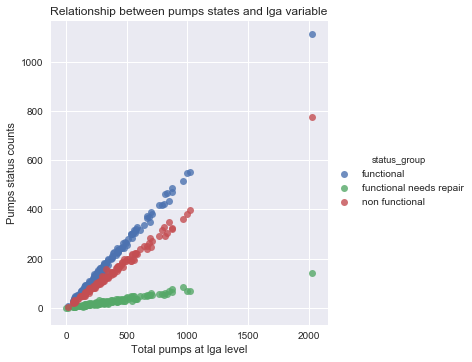

In [51]:
plot_status_split(df,'lga')

## Analyzing ward


In [53]:
print("ward has {} null values\n".format(sum(df['ward'].isnull())))
print("Counts at the ward levels:\n{}".format(df['ward'].value_counts()))
print("\nNumber of wards represented in the data set {}".format(df['ward'].value_counts().shape[0]))


ward has 0 null values

Counts at the ward levels:
Igosi            252
Imalinyi         198
Mdandu           189
Nduruma          177
Siha Kati        170
Kitunda          164
Msindo           158
Mishamo          157
Chalinze         153
Maji ya Chai     152
Usuka            152
Vikindu          137
Ngarenanyuki     134
Chanika          130
Matola           120
Mtwango          117
Zinga/Ikerege    115
Ifakara          114
Itete            114
Olkokola         109
Igongolo         108
Wanging'ombe     108
Kikatiti         107
Maramba          105
Mvomero          105
Maposeni         105
Nkungulu         103
Mlangali         103
Magomeni         103
Simbo            100
                ... 
Shilalo            1
Budushi            1
Igogo              1
Bombambili         1
Burungura          1
Matarawe           1
Ukata              1
Linda              1
Membe              1
Nkome              1
Murray             1
Bukoko             1
Machinjioni        1
Kimambi            1
Mkum

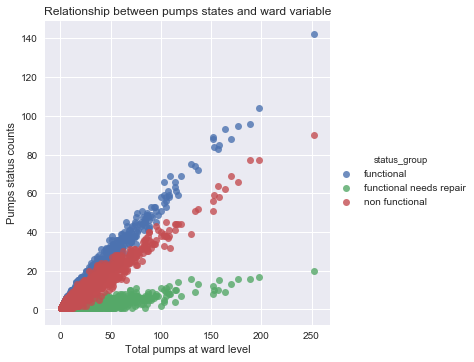

In [54]:
plot_status_split(df,'ward')

## Analyzing population
This is a quantative variable.

In [63]:
df['population'].value_counts()

0       17075
1        5625
200      1558
150      1511
250      1328
300      1178
100       931
50        900
500       812
350       783
120       724
400       615
60        570
30        503
40        441
80        420
450       403
20        376
600       364
230       307
75        243
1000      221
90        214
130       211
800       211
25        204
35        201
320       187
360       180
140       179
        ...  
721         1
593         1
974         1
1070        1
1486        1
1710        1
1742        1
431         1
687         1
879         1
975         1
1807        1
1839        1
1903        1
3982        1
2129        1
4210        1
2353        1
8500        1
2385        1
656         1
688         1
976         1
1040        1
1360        1
1680        1
1840        1
177         1
561         1
2670        1
Name: population, Length: 982, dtype: int64

Approximately 17000 observations have a population value of 0 and 5625 observations have 1. This is unlikely. Perhaps, these values might represent unknown values. Since the data is having outliers (see below plot), let us substitute 0 and 1 by the median value of population.

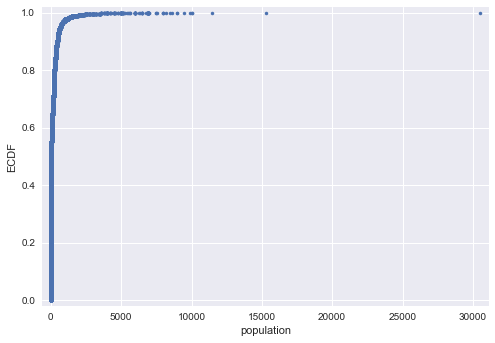

In [65]:
x,y = ECDF(df['population'])
plt.plot(x,y,marker='.',linestyle='none')
plt.xlabel("population")
plt.ylabel("ECDF")
plt.margins(0.02)
plt.show()

## Analyzing public_meeting
Not sure what this variable implies. It has 3 distinct values TRUE, FALSE and nulls.

In [67]:
df['public_meeting'].fillna('unknown',inplace=True)
df['public_meeting'].value_counts()

True       40739
False       4115
unknown     2638
Name: public_meeting, dtype: int64

We will create 3 dummy variables to represent the True, False, and unknown values of this variable.

## Analyzing recorded_by
Ignore this variable, as it has only one value "GeoData Consultants Ltd"

## Analyzing scheme_management

In [68]:
print("scheme_management has {} null values\n".format(sum(df['scheme_management'].isnull())))
print("Counts at the scheme_management levels:\n{}".format(df['scheme_management'].value_counts()))
print("\nNumber of scheme managements represented in the data set {}".format(df['scheme_management'].value_counts().shape[0]))


scheme_management has 3126 null values

Counts at the scheme_management levels:
VWC                 29360
WUG                  4209
Water authority      2543
WUA                  2301
Water Board          2196
Parastatal           1329
Private operator      863
Company               829
Other                 600
SWC                    80
Trust                  55
None                    1
Name: scheme_management, dtype: int64

Number of scheme managements represented in the data set 12


In [69]:
df['scheme_management'].fillna('unknown',inplace=True)
df['scheme_management'].value_counts()

VWC                 29360
WUG                  4209
unknown              3126
Water authority      2543
WUA                  2301
Water Board          2196
Parastatal           1329
Private operator      863
Company               829
Other                 600
SWC                    80
Trust                  55
None                    1
Name: scheme_management, dtype: int64

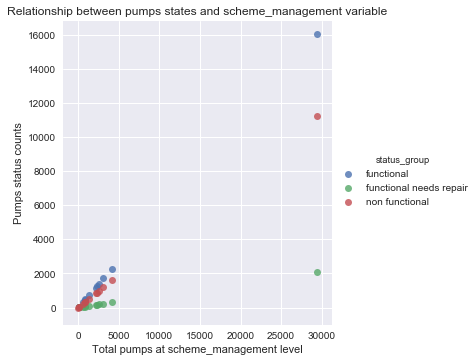

In [70]:
plot_status_split(df,'scheme_management')

Create dummy variables or probabilities

## Analyzing scheme_name

In [71]:
print("scheme_name has {} null values\n".format(sum(df['scheme_name'].isnull())))
print("Counts at the scheme_name levels:\n{}".format(df['scheme_name'].value_counts()))
print("\nNumber of scheme names represented in the data set {}".format(df['scheme_name'].value_counts().shape[0]))


scheme_name has 22503 null values

Counts at the scheme_name levels:
K                                        549
None                                     508
Borehole                                 445
Chalinze wate                            314
M                                        311
DANIDA                                   295
Government                               255
Ngana water supplied scheme              217
wanging'ombe water supply s              211
Bagamoyo wate                            186
wanging'ombe supply scheme               185
I                                        168
Uroki-Bomang'ombe water sup              160
N                                        160
Kirua kahe gravity water supply trust    157
Machumba estate pipe line                149
Makwale water supplied sche              132
Kijiji                                   132
S                                        130
mtwango water supply scheme              128
Losaa-Kia water supply         

Since the scheme has many unknown values, let us ignore this variable. We will revisit this decision later.

## Analyzing permit
It has 3 different values:
True, False, nulls

In [72]:
print("permit has {} null values\n".format(sum(df['permit'].isnull())))


print("Counts at the permit levels:\n{}".format(df['permit'].value_counts()))
print("\nNumber of permits represented in the data set {}".format(df['permit'].value_counts().shape[0]))


permit has 2439 null values

Counts at the permit levels:
True     31069
False    13984
Name: permit, dtype: int64

Number of permits represented in the data set 2


In [75]:
df['permit'].fillna('unknown',inplace=True)
df['permit'].value_counts()


True       31069
False      13984
unknown     2439
Name: permit, dtype: int64

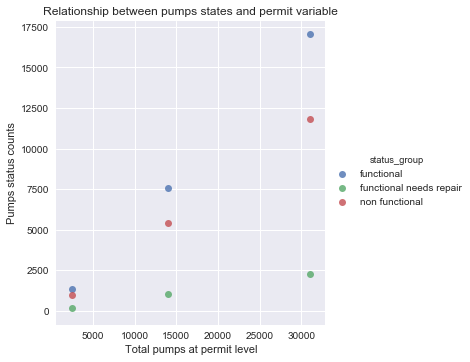

In [76]:
plot_status_split(df,'permit')

Create dummy variables for permit

## Analyzing construction_year

In [77]:
df['construction_year'].value_counts()

0       16520
2010     2098
2008     2081
2009     2051
2000     1684
2007     1303
2006     1162
2003     1045
2011     1018
2004      903
2002      878
2012      853
1995      815
1978      815
2005      815
1999      784
1990      771
1998      770
1985      766
1980      642
1996      634
1984      620
1982      602
1994      595
1972      569
1974      545
1997      519
1992      505
1993      486
2001      418
1988      414
1983      388
1975      349
1976      338
1986      337
1970      324
1991      263
1989      243
1987      231
1981      196
1977      167
1979      155
1973      142
2013      135
1971      123
1960       82
1967       68
1963       67
1968       54
1969       47
1964       29
1962       25
1965       17
1961       16
1966       15
Name: construction_year, dtype: int64

Looks like the unknown year is represented as 0. Try representing the years based on the probability of failures

## Analyzing extraction_type, extraction_type_group and extraction_type_class
These 3 variables are related to each other

In [91]:
print(df['extraction_type'].value_counts())
print("\nIt has {} null values".format(sum(df['extraction_type'].isnull())))

gravity                      21406
nira/tanira                   6582
other                         5178
submersible                   3799
swn 80                        2913
mono                          2293
india mark ii                 1884
afridev                       1376
ksb                           1125
other - rope pump              364
other - swn 81                 179
windmill                       103
india mark iii                  79
cemo                            74
other - play pump               66
walimi                          41
climax                          28
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

It has 0 null values


In [93]:
print(df['extraction_type_group'].value_counts())
print("\nIt has {} null values".format(sum(df['extraction_type_group'].isnull())))

gravity            21406
nira/tanira         6582
other               5178
submersible         4924
swn 80              2913
mono                2293
india mark ii       1884
afridev             1376
rope pump            364
other handpump       288
wind-powered         103
other motorpump      102
india mark iii        79
Name: extraction_type_group, dtype: int64

It has 0 null values


In [95]:
print(df['extraction_type_class'].value_counts())
print("\nIt has {} null values".format(sum(df['extraction_type_class'].isnull())))

gravity         21406
handpump        13122
other            5178
submersible      4924
motorpump        2395
rope pump         364
wind-powered      103
Name: extraction_type_class, dtype: int64

It has 0 null values


We should include only one of these variables. To determine which variable, let us use CV and pick the one that has the least CV error.

## Analyzing management and management_group
These two variables are also related.

In [96]:
print(df['management'].value_counts())
print("\nIt has {} null values".format(sum(df['management'].isnull())))

vwc                 32372
wug                  5229
water board          2379
wua                  2030
private operator     1595
parastatal           1395
water authority       704
other                 661
company               526
unknown               457
other - school         81
trust                  63
Name: management, dtype: int64

It has 0 null values


In [97]:
print(df['management_group'].value_counts())
print("\nIt has {} null values".format(sum(df['management_group'].isnull())))

user-group    42010
commercial     2888
parastatal     1395
other           742
unknown         457
Name: management_group, dtype: int64

It has 0 null values


Determine which variable to choose based on CV

## Analyzing paymet and payment_type
These two variables are also related

In [98]:
print(df['payment'].value_counts())
print("\nIt has {} null values".format(sum(df['payment'].isnull())))

never pay                20240
pay per bucket            7226
pay monthly               6620
unknown                   6501
pay when scheme fails     3138
pay annually              2927
other                      840
Name: payment, dtype: int64

It has 0 null values


In [99]:
print(df['payment_type'].value_counts())
print("\nIt has {} null values".format(sum(df['payment_type'].isnull())))

never pay     20240
per bucket     7226
monthly        6620
unknown        6501
on failure     3138
annually       2927
other           840
Name: payment_type, dtype: int64

It has 0 null values


Use payment_type variable

## Analyzing water_quality and quality_group

In [101]:
print(df['water_quality'].value_counts())
print("\nIt has {} null values".format(sum(df['water_quality'].isnull())))

soft                  40682
salty                  3867
unknown                1477
milky                   649
coloured                392
salty abandoned         256
fluoride                155
fluoride abandoned       14
Name: water_quality, dtype: int64

It has 0 null values


In [102]:
print(df['quality_group'].value_counts())
print("\nIt has {} null values".format(sum(df['quality_group'].isnull())))

good        40682
salty        4123
unknown      1477
milky         649
colored       392
fluoride      169
Name: quality_group, dtype: int64

It has 0 null values


Find which variable to use based on CV score

## Analyzing quantity and quantity_group

In [105]:
print(df['quantity'].value_counts())
print("\nIt has {} null values".format(sum(df['quantity'].isnull())))

enough          26506
insufficient    12116
dry              5005
seasonal         3237
unknown           628
Name: quantity, dtype: int64

It has 0 null values


In [106]:
print(df['quantity_group'].value_counts())
print("\nIt has {} null values".format(sum(df['quantity_group'].isnull())))

enough          26506
insufficient    12116
dry              5005
seasonal         3237
unknown           628
Name: quantity_group, dtype: int64

It has 0 null values


Use any variable

## Analyzing source, source_type and source_class

In [107]:
print(df['source'].value_counts())
print("\nIt has {} null values".format(sum(df['source'].isnull())))

spring                  13567
shallow well            13491
machine dbh              8794
river                    7743
rainwater harvesting     1836
hand dtw                  705
lake                      606
dam                       536
other                     162
unknown                    52
Name: source, dtype: int64

It has 0 null values


In [110]:
print(df['source_type'].value_counts())
print("\nIt has {} null values".format(sum(df['source_type'].isnull())))

spring                  13567
shallow well            13491
borehole                 9499
river/lake               8349
rainwater harvesting     1836
dam                       536
other                     214
Name: source_type, dtype: int64

It has 0 null values


In [111]:
print(df['source_class'].value_counts())
print("\nIt has {} null values".format(sum(df['source_class'].isnull())))

groundwater    36557
surface        10721
unknown          214
Name: source_class, dtype: int64

It has 0 null values


Use source_type (unknown in source is converted to other in source_type).

Use source_class

## Analyzing waterpoint_type and waterpoint_type_group

In [113]:
print(df['waterpoint_type'].value_counts())
print("\nIt has {} null values".format(sum(df['waterpoint_type'].isnull())))

communal standpipe             22809
hand pump                      13937
other                           5173
communal standpipe multiple     4869
improved spring                  609
cattle trough                     89
dam                                6
Name: waterpoint_type, dtype: int64

It has 0 null values


In [114]:
print(df['waterpoint_type_group'].value_counts())
print("\nIt has {} null values".format(sum(df['waterpoint_type_group'].isnull())))

communal standpipe    27678
hand pump             13937
other                  5173
improved spring         609
cattle trough            89
dam                       6
Name: waterpoint_type_group, dtype: int64

It has 0 null values


Decide by CV method

## Analyzing latitude and longitude

In [117]:
df['population'].replace(to_replace=25,value=0,inplace=True)

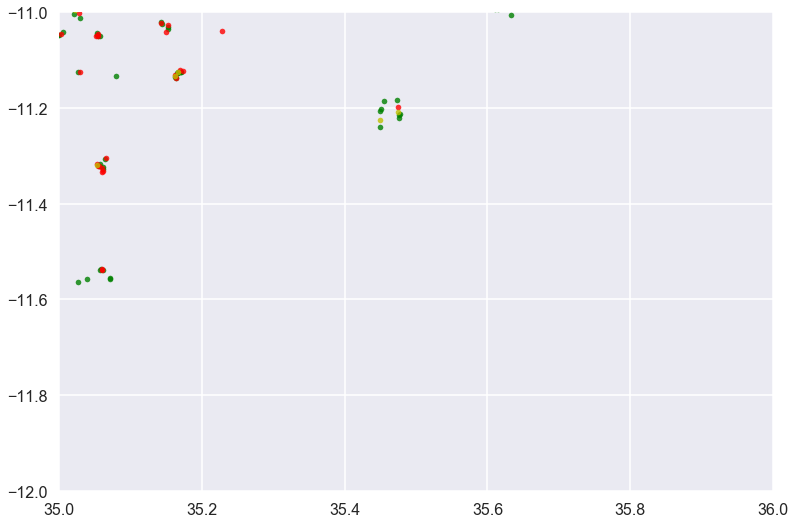

In [182]:
plt.plot(df[df['status_group']=='functional']['longitude_new'],
        df[df['status_group']=='functional']['latitude_new'],color='g',linestyle='none',marker='.',alpha=0.8)

plt.plot(df[df['status_group']=='non functional']['longitude_new'],
        df[df['status_group']=='non functional']['latitude_new'],color='r',linestyle='none',marker='.',alpha=0.8)

plt.plot(df[df['status_group']=='functional needs repair']['longitude_new'],
        df[df['status_group']=='functional needs repair']['latitude_new'],color='y',linestyle='none',marker='.',alpha=0.8)
#plt.ylim(-2.5,-2.4)
#plt.xlim(30.5,30.75)
plt.ylim(-12,-11)
plt.xlim(35,36)
plt.show()

It might help to add 3 additional variables:
* distance to the nearest functional pump
* distance to the nearest non-functional pump
* distance to the nearest need to repair pump

I am not sure how complex it is to compute these distances.